In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import tensorflow as tf
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

import os
import platform

# 한글 폰트 사용시 마이너스 폰트 깨짐 해결
if platform.system() == 'Darwin': # 맥
    plt.rc('font', family='AppleGothic') 
else: # 윈도우
    plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import optuna


In [5]:
# 데이터 로드
data = pd.read_csv('C:\\ex\\test\\Telco-Customer-Churn.csv')  # 여기서 파일 경로를 입력하세요.

# 'TotalCharges' 열을 숫자로 변환, 변환되지 않는 값은 NaN으로 설정
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# 결측치 처리
data = data.fillna(method='ffill')

# 레이블 인코딩 및 범주형 변수 인코딩
le = LabelEncoder()
data['Churn'] = le.fit_transform(data['Churn'])
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()

# 'customerID' 열 삭제
data.drop(['customerID'], axis=1, inplace=True)

# 파생 변수 생성
# 1. tenure bin
data['tenure_short'] = data['tenure'].apply(lambda x: 1 if x < 24 else 0)
data['tenure_mid'] = data['tenure'].apply(lambda x: 1 if x >= 24 and x < 48 else 0)
data['tenure_long'] = data['tenure'].apply(lambda x: 1 if x >= 48 else 0)

# 2. Monthly Charges group
data['MonthlyCharges_group1'] = data['MonthlyCharges'].apply(lambda x: 1 if x < 30 else 0)
data['MonthlyCharges_group2'] = data['MonthlyCharges'].apply(lambda x: 1 if x >= 30 and x < 60 else 0)
data['MonthlyCharges_group3'] = data['MonthlyCharges'].apply(lambda x: 1 if x >= 60 and x < 90 else 0)
data['MonthlyCharges_group4'] = data['MonthlyCharges'].apply(lambda x: 1 if x >= 90 else 0)

# 3. Total Charges group
data['TotalCharges_group1'] = data['TotalCharges'].apply(lambda x: 1 if x < 3000 else 0)
data['TotalCharges_group2'] = data['TotalCharges'].apply(lambda x: 1 if x >= 3000 and x < 6000 else 0)
data['TotalCharges_group3'] = data['TotalCharges'].apply(lambda x: 1 if x >= 6000 else 0)

# CatBoost를 위한 데이터 복사
catboost_data = data.copy()

# CatBoost를 위한 범주형 변수 인덱스
cat_features_index = [catboost_data.columns.get_loc(col) for col in categorical_columns if col != 'customerID']

# get_dummies
ramain_vars = ['Churn', 'tenure_short', 'tenure_mid', 'tenure_long', 'MonthlyCharges_group1',
               'MonthlyCharges_group2', 'MonthlyCharges_group3', 'MonthlyCharges_group4',
               'TotalCharges_group1', 'TotalCharges_group2', 'TotalCharges_group3',
               'tenure', 'MonthlyCharges', 'TotalCharges']
categorical_vars = data.drop(ramain_vars, axis=1)
cat_df = pd.get_dummies(categorical_vars).astype(int)

data = pd.concat([cat_df, data[ramain_vars]], axis=1)

# 연속형 변수 스케일링 (CatBoost는 스케일링이 필요하지 않지만 다른 모델을 위해)
scaler = StandardScaler()
data[ramain_vars] = scaler.fit_transform(data[ramain_vars])

# 훈련/테스트 데이터 분리
X = data.drop('Churn', axis=1)
y = data['Churn'].astype(int)  # y를 정수형으로 변환
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# CatBoost 하이퍼파라미터 튜닝 - GridSearchCV
param_grid_catboost = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [200, 500, 1000],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 50, 100, 150]
}
grid_search_catboost = GridSearchCV(estimator=CatBoostClassifier(cat_features=cat_features_index, verbose=0), param_grid=param_grid_catboost, cv=3, scoring='accuracy')
grid_search_catboost.fit(catboost_data.drop(['Churn'], axis=1), catboost_data['Churn'])

# Optuna를 사용한 CatBoost 하이퍼파라미터 튜닝
def objective(trial):
    param = {
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'iterations': trial.suggest_int('iterations', 200, 1000),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 9),
        'border_count': trial.suggest_int('border_count', 32, 150),
        'task_type': 'CPU',
        'cat_features': cat_features_index
    }
    
    model = CatBoostClassifier(**param, verbose=0)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)
    
    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 최적의 파라미터 출력
best_params_optuna = study.best_params
print("Best hyperparameters from Optuna: ", best_params_optuna)

# 최적의 모델 학습
best_catboost_model_optuna = CatBoostClassifier(**best_params_optuna, verbose=0)
best_catboost_model_optuna.fit(X_train, y_train)


[I 2024-07-08 02:45:21,134] A new study created in memory with name: no-name-b6a5fd84-8ecd-4d83-a71a-a209414160a5
[I 2024-07-08 02:45:21,666] Trial 0 finished with value: 0.8647121844172783 and parameters: {'depth': 7, 'learning_rate': 0.038697003189772816, 'iterations': 382, 'l2_leaf_reg': 1, 'border_count': 95}. Best is trial 0 with value: 0.8647121844172783.
[I 2024-07-08 02:45:22,298] Trial 1 finished with value: 0.8668626497044729 and parameters: {'depth': 5, 'learning_rate': 0.03081632993845418, 'iterations': 497, 'l2_leaf_reg': 4, 'border_count': 94}. Best is trial 1 with value: 0.8668626497044729.
[I 2024-07-08 02:45:22,665] Trial 2 finished with value: 0.8647898185431696 and parameters: {'depth': 5, 'learning_rate': 0.10099627033931532, 'iterations': 766, 'l2_leaf_reg': 2, 'border_count': 145}. Best is trial 1 with value: 0.8668626497044729.
[I 2024-07-08 02:45:23,047] Trial 3 finished with value: 0.8646643100396452 and parameters: {'depth': 4, 'learning_rate': 0.0793863910536

Best hyperparameters from Optuna:  {'depth': 5, 'learning_rate': 0.07525300861405301, 'iterations': 490, 'l2_leaf_reg': 3, 'border_count': 122}



Model Evaluation Metrics for CatBoost (GridSearchCV):
Accuracy: 0.8161816891412349
Precision: 0.7007042253521126
Recall: 0.5335120643431636
F1 Score: 0.6057838660578386
ROC AUC: 0.872677445733746
Confusion Matrix: 
[[951  85]
 [174 199]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1036
           1       0.70      0.53      0.61       373

    accuracy                           0.82      1409
   macro avg       0.77      0.73      0.74      1409
weighted avg       0.81      0.82      0.81      1409


Model Evaluation Metrics for CatBoost (Optuna):
Accuracy: 0.7998580553584103
Precision: 0.6491803278688525
Recall: 0.5308310991957105
F1 Score: 0.584070796460177
ROC AUC: 0.8560844452265364
Confusion Matrix: 
[[929 107]
 [175 198]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1036
           1       0.65      0.53      0.58 

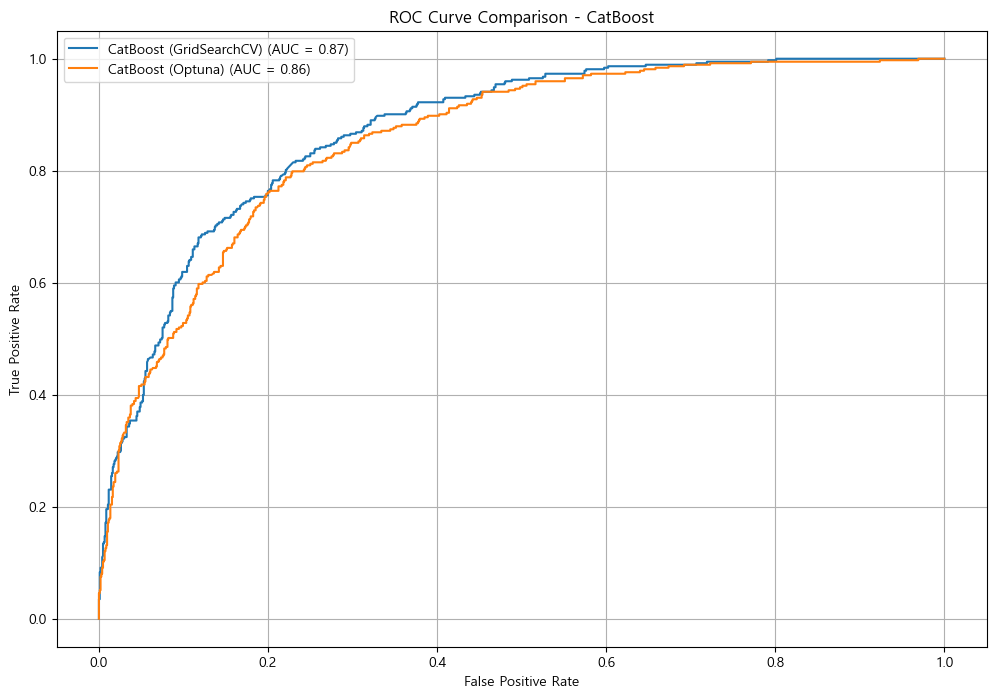

In [14]:
# 모델 평가 함수
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print(f'\nModel Evaluation Metrics for {model_name}:')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'F1 Score: {f1_score(y_test, y_pred)}')
    print(f'ROC AUC: {roc_auc_score(y_test, y_pred_proba)}')
    print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    return fpr, tpr, roc_auc_score(y_test, y_pred_proba)

# 모델별 평가 및 비교
plt.figure(figsize=(12, 8))

# GridSearchCV로 튜닝한 CatBoost 모델 평가
cat_X_test = catboost_data.drop(['Churn'], axis=1).iloc[X_test.index, :]
fpr, tpr, auc = evaluate_model(grid_search_catboost.best_estimator_, cat_X_test, y_test, "CatBoost (GridSearchCV)")
plt.plot(fpr, tpr, label=f'CatBoost (GridSearchCV) (AUC = {auc:.2f})')

# Optuna로 튜닝한 CatBoost 모델 평가
fpr, tpr, auc = evaluate_model(best_catboost_model_optuna, X_test, y_test, "CatBoost (Optuna)")
plt.plot(fpr, tpr, label=f'CatBoost (Optuna) (AUC = {auc:.2f})')

# 그래프 꾸미기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - CatBoost')
plt.legend(loc='best')
plt.grid()
plt.show()



Model Evaluation Metrics for CatBoost (GridSearchCV):
Accuracy: 0.8161816891412349
Precision: 0.7007042253521126
Recall: 0.5335120643431636
F1 Score: 0.6057838660578386
ROC AUC: 0.872677445733746
Confusion Matrix: 
[[951  85]
 [174 199]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1036
           1       0.70      0.53      0.61       373

    accuracy                           0.82      1409
   macro avg       0.77      0.73      0.74      1409
weighted avg       0.81      0.82      0.81      1409


Model Evaluation Metrics for CatBoost (Optuna):
Accuracy: 0.7998580553584103
Precision: 0.6491803278688525
Recall: 0.5308310991957105
F1 Score: 0.584070796460177
ROC AUC: 0.8560844452265364
Confusion Matrix: 
[[929 107]
 [175 198]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1036
           1       0.65      0.53      0.58 

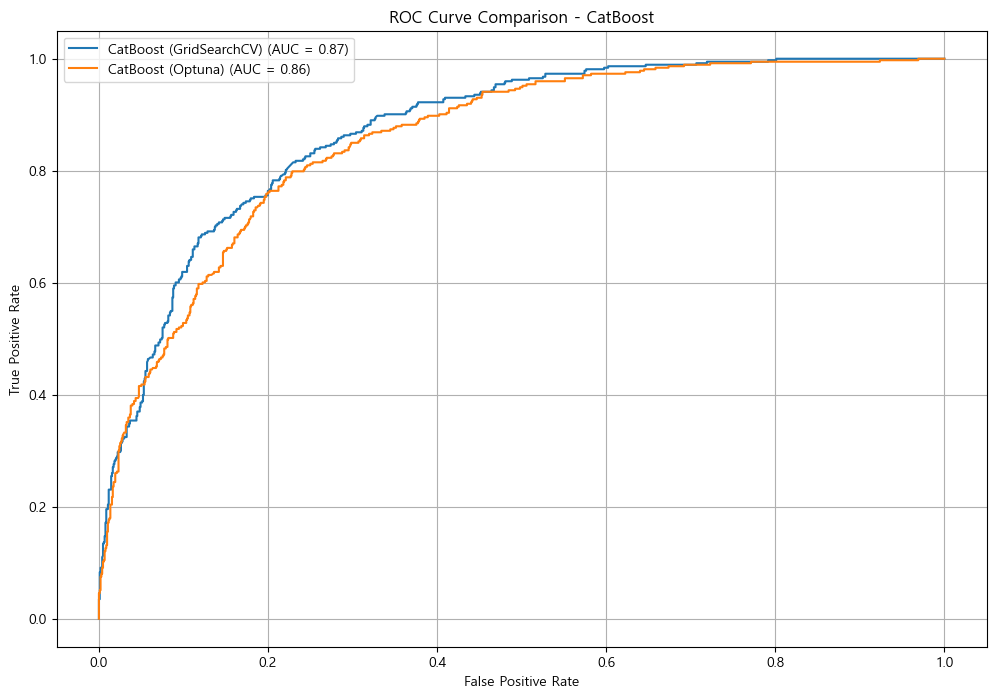


Model Evaluation Metrics for Loaded CatBoost (GridSearchCV):
Accuracy: 0.8161816891412349
Precision: 0.7007042253521126
Recall: 0.5335120643431636
F1 Score: 0.6057838660578386
ROC AUC: 0.872677445733746
Confusion Matrix: 
[[951  85]
 [174 199]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1036
           1       0.70      0.53      0.61       373

    accuracy                           0.82      1409
   macro avg       0.77      0.73      0.74      1409
weighted avg       0.81      0.82      0.81      1409


Model Evaluation Metrics for Loaded CatBoost (Optuna):
Accuracy: 0.7998580553584103
Precision: 0.6491803278688525
Recall: 0.5308310991957105
F1 Score: 0.584070796460177
ROC AUC: 0.8560844452265364
Confusion Matrix: 
[[929 107]
 [175 198]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1036
           1       0.65      0

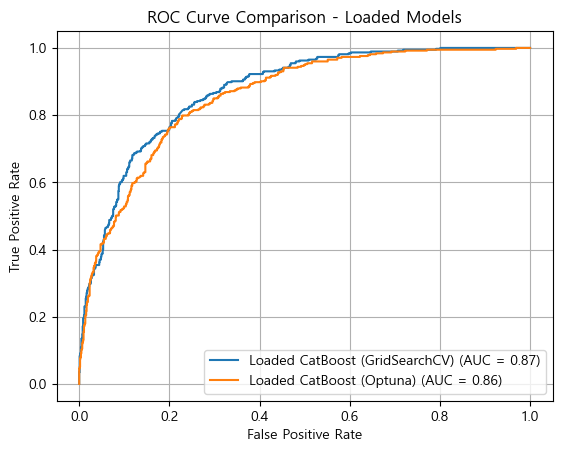

In [16]:
import joblib

# 모델 평가 함수
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print(f'\nModel Evaluation Metrics for {model_name}:')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'F1 Score: {f1_score(y_test, y_pred)}')
    print(f'ROC AUC: {roc_auc_score(y_test, y_pred_proba)}')
    print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    return fpr, tpr, roc_auc_score(y_test, y_pred_proba)

# 모델별 평가 및 비교
plt.figure(figsize=(12, 8))

# GridSearchCV로 튜닝한 CatBoost 모델 평가
cat_X_test = catboost_data.drop(['Churn'], axis=1).iloc[X_test.index, :]
fpr, tpr, auc = evaluate_model(grid_search_catboost.best_estimator_, cat_X_test, y_test, "CatBoost (GridSearchCV)")
plt.plot(fpr, tpr, label=f'CatBoost (GridSearchCV) (AUC = {auc:.2f})')

# Optuna로 튜닝한 CatBoost 모델 평가
fpr, tpr, auc = evaluate_model(best_catboost_model_optuna, X_test, y_test, "CatBoost (Optuna)")
plt.plot(fpr, tpr, label=f'CatBoost (Optuna) (AUC = {auc:.2f})')

# 그래프 꾸미기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - CatBoost')
plt.legend(loc='best')
plt.grid()
plt.show()

# 학습된 모델 저장
grid_search_catboost.best_estimator_.save_model("catboost_gridsearch_model.cbm")
best_catboost_model_optuna.save_model("catboost_optuna_model.cbm")

# 학습된 모델 로드
loaded_gridsearch_model = CatBoostClassifier()
loaded_gridsearch_model.load_model("catboost_gridsearch_model.cbm")

loaded_optuna_model = CatBoostClassifier()
loaded_optuna_model.load_model("catboost_optuna_model.cbm")

# 로드한 모델 평가
fpr, tpr, auc = evaluate_model(loaded_gridsearch_model, cat_X_test, y_test, "Loaded CatBoost (GridSearchCV)")
plt.plot(fpr, tpr, label=f'Loaded CatBoost (GridSearchCV) (AUC = {auc:.2f})')

fpr, tpr, auc = evaluate_model(loaded_optuna_model, X_test, y_test, "Loaded CatBoost (Optuna)")
plt.plot(fpr, tpr, label=f'Loaded CatBoost (Optuna) (AUC = {auc:.2f})')

# 그래프 꾸미기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - Loaded Models')
plt.legend(loc='best')
plt.grid()
plt.show()
